# A joint model CAR (model 1) 
# With Crossvalidation
## Two independent processes
 $$ [P , S ] = [P ] [ S ] $$

In [1]:
## Import code:
setwd('/apps/external_plugins/biospytial_rwrapper/biospytial.rwrapper/R/')

In [2]:
rm(list=ls())                                                                                     
source("init_data.R")                                                                             
# load the building function                                                                      
source("joint.binomial.bymCARModel1.R")

Loading required package: MASS
Loading required package: Rcpp

Attaching package: ‘dplyr’

The following object is masked from ‘package:MASS’:

    select

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Warning message:
“The `printer` argument is deprecated as of rlang 0.3.0.
This warning is displayed once per session.”

Cross validation of CAR models is not straight forward due to its spatial structure (lattice). 
The approach for this would be with data augmentation.
removing the value for validate.data and change it o NA.

After the model, I'll extract the resulting probability and perform a simple ROC curve.


In [3]:
## MCMC parameters burnin and sample to be consistent with the other models
#n.sample = 10000                                                                                  
#burnin=10000                                                                                      
#postburnin = burnin +1000                                                                         

n.sample = 10000                                                                                 
burnin=5000                                                                                      
postburnin = burnin +1000                                                                         


thin = 1                                                                                          
verbose = TRUE                           

## Make ROC curve
library(pROC)
library('caret')
#trains = createFolds(y = DataFrame$species, k=7, returnTrain = TRUE)
validate = createFolds(y = DataFrame$species, k=7, returnTrain = FALSE)

DataFrame$presences <- DataFrame$species

l <- list()
i = 1
DataFrame$predicted_values_CV <- NA
for (fold in validate) {
    
    observed.presences <- DataFrame$species[fold]
    ## Substitue by NA
    DataFrame$species[fold] <- NA
    results  <- joint.binomial.bymCARModel1(formula_S = formula_sample, 
                                        formula_P = formula_presence,
                                        n.sample=n.sample,
                                        data = DataFrame,
                                        burnin=burnin,
                                        postburnin=postburnin,
                                        thin=thin,
                                        verbose=TRUE) 

    DataFrame$species <- DataFrame$presences
    ## Return original values
    DataFrame$predicted_values_CV[fold] <- results$fitted.values[fold]
    predicted.probability = results$fitted.values[fold]
    pROC_obj <- roc(observed.presences,predicted.probability)

    l[[i]] <- pROC_obj
    i = i + 1
}

Type 'citation("pROC")' for a citation.

Attaching package: ‘pROC’

The following objects are masked from ‘package:stats’:

    cov, smooth, var

Loading required package: lattice
Loading required package: ggplot2

Attaching package: ‘caret’

The following object is masked from ‘package:purrr’:

    lift



Setting up the model.
Performing burnin period for Sample Effort Model 
  |======================================================================| 100%
Summarising results.
Finished in  52.5 seconds.
Setting up the model.
Performing burnin period for Presence model 
  |======================================================================| 100%
Summarising results.
Finished in  52.4 seconds.
Sampling from the joint model 10000 post burnin and thinned (if requested) samples.
  |======================================================================| 100%
[1] "Compiling summary for S process"
[1] "Compiling summary for the P process"


Setting levels: control = 0, case = 1
Setting direction: controls < cases


Setting up the model.
Performing burnin period for Sample Effort Model 
  |======================================================================| 100%
Summarising results.
Finished in  52.3 seconds.
Setting up the model.
Performing burnin period for Presence model 
  |======================================================================| 100%
Summarising results.
Finished in  51.7 seconds.
Sampling from the joint model 10000 post burnin and thinned (if requested) samples.
  |======================================================================| 100%
[1] "Compiling summary for S process"
[1] "Compiling summary for the P process"


Setting levels: control = 0, case = 1
Setting direction: controls < cases


Setting up the model.
Performing burnin period for Sample Effort Model 
  |======================================================================| 100%
Summarising results.
Finished in  51.5 seconds.
Setting up the model.
Performing burnin period for Presence model 
  |======================================================================| 100%
Summarising results.
Finished in  52.1 seconds.
Sampling from the joint model 10000 post burnin and thinned (if requested) samples.
  |======================================================================| 100%
[1] "Compiling summary for S process"
[1] "Compiling summary for the P process"


Setting levels: control = 0, case = 1
Setting direction: controls < cases


Setting up the model.
Performing burnin period for Sample Effort Model 
  |======================================================================| 100%
Summarising results.
Finished in  51.6 seconds.
Setting up the model.
Performing burnin period for Presence model 
  |======================================================================| 100%
Summarising results.
Finished in  51.7 seconds.
Sampling from the joint model 10000 post burnin and thinned (if requested) samples.
  |======================================================================| 100%
[1] "Compiling summary for S process"
[1] "Compiling summary for the P process"


Setting levels: control = 0, case = 1
Setting direction: controls < cases


Setting up the model.
Performing burnin period for Sample Effort Model 
  |======================================================================| 100%
Summarising results.
Finished in  52.7 seconds.
Setting up the model.
Performing burnin period for Presence model 
  |======================================================================| 100%
Summarising results.
Finished in  52.2 seconds.
Sampling from the joint model 10000 post burnin and thinned (if requested) samples.
  |======================================================================| 100%
[1] "Compiling summary for S process"
[1] "Compiling summary for the P process"


Setting levels: control = 0, case = 1
Setting direction: controls < cases


Setting up the model.
Performing burnin period for Sample Effort Model 
  |======================================================================| 100%
Summarising results.
Finished in  52.5 seconds.
Setting up the model.
Performing burnin period for Presence model 
  |======================================================================| 100%
Summarising results.
Finished in  51.3 seconds.
Sampling from the joint model 10000 post burnin and thinned (if requested) samples.
  |======================================================================| 100%
[1] "Compiling summary for S process"
[1] "Compiling summary for the P process"


Setting levels: control = 0, case = 1
Setting direction: controls < cases


Setting up the model.
Performing burnin period for Sample Effort Model 
  |======================================================================| 100%
Summarising results.
Finished in  52.9 seconds.
Setting up the model.
Performing burnin period for Presence model 
  |======================================================================| 100%
Summarising results.
Finished in  51.4 seconds.
Sampling from the joint model 10000 post burnin and thinned (if requested) samples.
  |======================================================================| 100%
[1] "Compiling summary for S process"
[1] "Compiling summary for the P process"


Setting levels: control = 0, case = 1
Setting direction: controls < cases


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Warning message in plot.ci.se(sens.ci, type = "shape", col = "lightblue"):
“Low definition shape.”

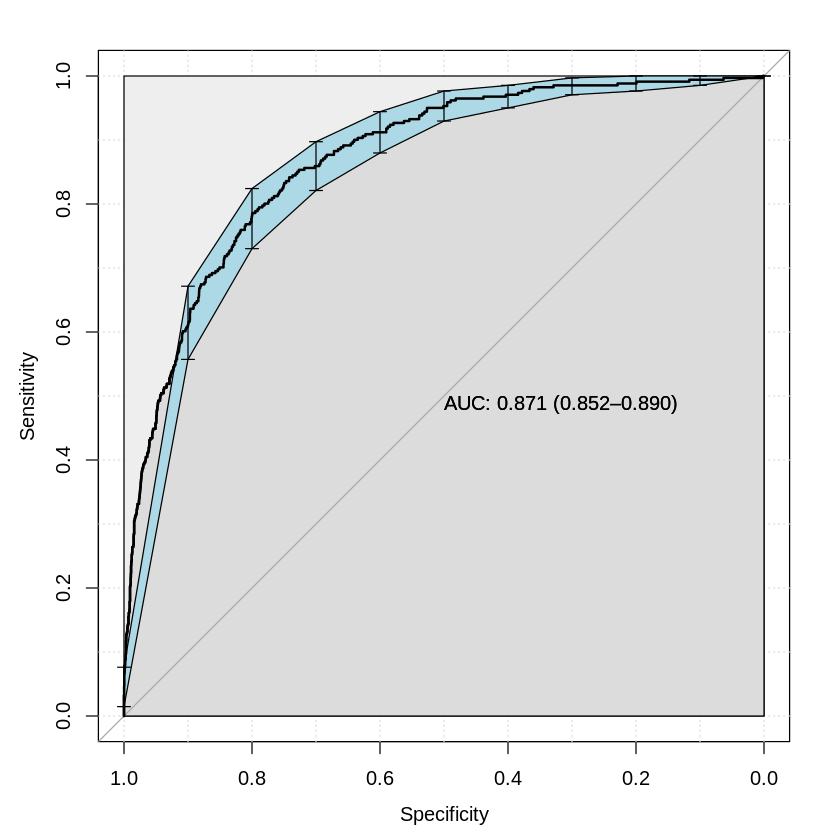

In [4]:
pROC_obj <- roc(DataFrame$presences,DataFrame$predicted_values_CV,
               smoothed= TRUE,
               ci = TRUE, ci.alpha=0.9, stratified=FALSE,
               plot=TRUE, auc.polygon=TRUE, max.auc.polygon=TRUE, grid=TRUE,
               print.auc=TRUE, show.thres=TRUE)
sens.ci <- ci.se(pROC_obj)
plot(sens.ci,type="shape",col="lightblue")
plot(sens.ci, type="bars")



## Generate results

In [2]:
## Complete model
results  <- joint.binomial.bymCARModel1(formula_S = formula_sample, 
                                        formula_P = formula_presence,
                                        n.sample=n.sample,
                                        data = DataFrame,
                                        burnin=burnin,
                                        postburnin=postburnin,
                                        thin=thin,
                                        verbose=TRUE)

ERROR: Error in joint.binomial.bymCARModel1(formula_S = formula_sample, formula_P = formula_presence, : could not find function "joint.binomial.bymCARModel1"


In [1]:
results$summary.results

ERROR: Error in eval(expr, envir, enclos): object 'results' not found


In [29]:
results$S$summary.results

,Median,2.5%,97.5%,n.sample,% accept,n.effective,Geweke.diag
(Intercept),2.3674,0.7601,5.1300,10000,60.3,2.6,0.0
Disttoroadm,-0.0002,-0.0004,-0.0001,10000,60.3,1249.6,0.4
Populationm,0.0000,-0.0001,0.0001,10000,60.3,1625.5,0.6
tau2,5.9817,3.9310,11.4287,10000,100.0,11.4,-1.4
sigma2,0.1538,0.0550,1.1142,10000,100.0,2.7,-1.6


In [30]:
results$P$summary.results

,Median,2.5%,97.5%,n.sample,% accept,n.effective,Geweke.diag
(Intercept),-3.5720,-5.9809,-0.9618,10000,63.7,9.4,-2.3
Elevationm,0.0001,-0.0002,0.0005,10000,63.7,287.2,0.3
MeanTempm,-0.0005,-0.0009,0.0000,10000,63.7,109.7,1.3
tau2,19.4756,13.1363,39.6048,10000,100.0,8.0,-1.3
sigma2,0.0641,0.0280,0.1470,10000,100.0,4.6,3.3


In [18]:
meanfitted = results$fitted.values

In [31]:
fitted_samples = cbind(results$S$samples$fitted,results$P$samples$fitted)

In [32]:
post.sample_p = data.frame(results$S$samples$fitted)
post.presence_p = data.frame(results$P$samples$fitted)
post.joint = data.frame(results$samples$fitted.joint)

In [36]:
pss  <- post.sample_p %>% mutate_all(function(p) rbernoulli(1,p))
pps <- post.presence_p %>% mutate_all(function(p) rbernoulli(1,p))
ptot <- post.joint %>% mutate_all(function(p) rbernoulli(1,p))

In [37]:
sumpt <- colSums(ptot)
sumps <- colSums(pss)
sumpp <- colSums(pps)

In [38]:
nsamples = dim(ptot)[1]
print(nsamples)
ProbPS <- sumpt / nsamples
ProbP <- sumpp / nsamples
ProbS <- sumps / nsamples

[1] 10000


In [39]:
## Compute independent joint distribution
library(boot)

fitted_presences = apply(results$P$samples$fitted,MARGIN=1,identity)
fitted_sample = apply(results$S$samples$fitted,MARGIN=1,identity)
fitted_total = apply(results$samples$fitted,MARGIN=1,identity)

re_presence = apply(results$P$samples$psi,MARGIN=1,identity)
re_sample = apply(results$S$samples$psi,MARGIN=1,identity)

In [40]:
getUpperLowerCI <- function(fitted_sample,prefix="",MARGIN=1){
    fp = partial(quantile,probs=c(0.025,0.5,0.975))
    quants =apply(X = fitted_sample,FUN = fp,MARGIN)
    mfitt = apply(fitted_sample,mean,MARGIN = MARGIN)
    vfitt = apply(fitted_sample,var,MARGIN = MARGIN)
    new_data = cbind(t(quants),mfitt,vfitt)
    l = as.list(c("q025","median","q0975","mean","variance"))
    nnames = lapply(l,function (x){return(paste(prefix,x,sep = '_'))})
    colnames(new_data) = nnames
    return(new_data)
}

P = getUpperLowerCI(fitted_presences,prefix = 'P')
S = getUpperLowerCI(fitted_sample,prefix = 'S')
PS = getUpperLowerCI(fitted_total,prefix = 'PS')
Gp = getUpperLowerCI(re_presence,prefix = 'Gp')
Gs = getUpperLowerCI(re_sample,prefix = 'Gs')



In [41]:
## save to posterity
# Save output sample to display in python
## Save the complete chain trace for analysing in Python,
#TDF = read.csv("/outputs/training_data_sample_puebla_p9_abies_pinophyta.csv")
## Order it according to the id of the cell
## This is important because the adjancy matrix rows need to be the same

## No needed because DataFrame object already loaded and without no-neighbour (i.e. same size as fitted values)
#TDF = TDF[order(TDF$cell_ids),]
TDF = DataFrame[order(DataFrame$cellids),]

In [43]:
chain = cbind(TDF$cellids,Gp,Gs,P,S,PS,ProbPS,ProbP,ProbS)
file_ = '/outputs/presence_only_models/modelCAR_model1_fitted2.csv'
write.csv(chain,file_)